In [1]:
import pdb
from math import log10, floor

import numpy as np
import scipy.optimize as op
import scipy.special as spec
from scipy import stats
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import corner

import astropy
from astropy import stats as astrostats
from astropy.timeseries import LombScargle

import emcee
import radvel

%matplotlib inline

# Assuming a polished list of known planets and candidates in the legacy sample, explore and visualize properties such as mass, host star metallicity, etc.

In [2]:
data = pd.read_csv('legacy_tables/system_props.csv')

In [3]:
specmatch = pd.read_csv('/Users/lee/Academics/Astronomy/Planets/CLSI/legacy_tables/legacy_specmatch_medians.csv')
smsyn = specmatch.query('teff_emp > 4700')
smemp = specmatch.query('teff_emp <= 4700')
fe_select = specmatch['fe_c'].to_list()

In [4]:
specmatch['mass_precision'] = specmatch['mass_err_c']/specmatch['mass_c']

In [5]:
print(np.argmin(specmatch['mass_precision']),
      np.amin(specmatch['mass_precision']), 
      np.median(specmatch['mass_precision']),
      np.amax(specmatch['mass_precision']))

388 0.007943381536013443 0.03558714066329477 0.19931904677542944


In [7]:
masses_only = pd.read_csv('legacy_tables/planet_list.csv')
trends = pd.read_csv('legacy_tables/trend_list.csv')

## Sort the planets into real, new candidates, known.

In [8]:
masses_real   = masses_only.query('status != "N" and status != "A" and status != "R"').reset_index(drop=True)
masses_good   = masses_real.query('mass != "nan"').reset_index(drop=True)
masses_s      = masses_good.query('status == "S" or status == "SS"').reset_index(drop=True)
masses_planet = masses_good.query('status != "S" and status != "SS"').reset_index(drop=True)
masses_old    = masses_planet.query('status == "K"').reset_index(drop=True)
masses_new    = masses_planet.query('status == "C" or status == "J"').reset_index(drop=True)

In [9]:
sub_20 = masses_real.query('mass < 20')

In [16]:
len()

132

In [12]:
sub_20.query('status == "S"')

,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,e_68,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path
116,171,28185,S,2.0,4.776824,39.775688,12.144566,83.238008,8.216415,15.885361,...,0.327267,0.015720,0.004211,0.001974,0.009168,1.826607,2.539057,0.001974,0.009168,/data/user/lrosenth/legacy/final_run/28185/281...
138,198,42581,S,1.0,1.270530,66.441761,-583.865870,849.297925,21.116403,71.504138,...,0.525278,0.000105,0.000009,0.000003,0.000086,6.382023,11.757467,0.000003,0.000086,/data/user/lrosenth/legacy/final_run/42581/425...
178,254,8375,S,2.0,19.875104,476.984403,22.231022,2686.497151,6.482856,27.444322,...,0.383029,0.218289,0.012154,0.004361,0.031455,0.946240,1.947977,0.004361,0.031455,/data/user/lrosenth/legacy/final_run/8375/8375...


In [13]:
masses_new

,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,e_68,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path
0,6,107148,C,2.0,0.067845,0.062632,0.052812,0.072330,0.140652,1.406347e-01,...,0.401911,69.539101,6.951497e+01,6.363609e+01,7.576530e+01,0.223976,0.223996,6.363609e+01,7.576530e+01,/data/user/lrosenth/legacy/final_run/107148/10...
1,40,136925,C,1.0,1.074472,1.076818,0.885964,1.281420,4.638578,4.680605e+00,...,0.715150,0.060771,5.795191e-02,4.915876e-02,6.446792e-02,1.302672,1.318234,4.915876e-02,6.446792e-02,/data/user/lrosenth/legacy/final_run/136925/13...
2,44,141004,C,1.0,0.043896,0.042840,0.038372,0.047503,0.123777,1.237898e-01,...,0.215525,135.018671,1.350186e+02,1.234917e+02,1.474630e+02,0.189741,0.189741,1.234917e+02,1.474630e+02,/data/user/lrosenth/legacy/final_run/141004/14...
3,57,145675,C,2.0,5.691600,5.841370,4.811323,7.203498,15.949545,1.642631e+01,...,0.530049,0.002883,2.718023e-03,1.106413e-03,5.040733e-03,2.791166,2.832672,1.106413e-03,5.040733e-03,/data/user/lrosenth/legacy/final_run/145675/14...
4,71,156668,C,1.0,0.101324,0.099113,0.091371,0.107005,1.570776,1.570483e+00,...,0.127107,0.115864,1.158330e-01,1.056408e-01,1.269779e-01,1.108593,1.108668,1.056408e-01,1.269779e-01,/data/user/lrosenth/legacy/final_run/156668/15...
5,81,164922,C,3.0,0.034078,0.033098,0.030035,0.036199,0.229199,2.292044e-01,...,0.123719,14.011769,1.400652e+01,1.280288e+01,1.532656e+01,0.334300,0.334331,1.280288e+01,1.532656e+01,/data/user/lrosenth/legacy/final_run/164922/16...
6,82,164922,C,4.0,0.015214,0.014872,0.012793,0.016945,0.102336,1.023287e-01,...,0.255071,70.284937,7.027666e+01,6.423174e+01,7.689646e+01,0.223380,0.223386,6.423174e+01,7.689646e+01,/data/user/lrosenth/legacy/final_run/164922/16...
7,87,168009,C,2.0,0.030927,0.030038,0.026331,0.033825,0.119264,1.192519e-01,...,0.172219,102.504191,1.024703e+02,9.372066e+01,1.120860e+02,0.203270,0.203287,9.372066e+01,1.120860e+02,/data/user/lrosenth/legacy/final_run/168009/16...
8,136,213472,C,1.0,4.997914,-1091.641579,-1137.561113,-1006.543430,18.601278,5.417364e+10,...,0.637527,0.005693,6.770000e-22,1.480000e-22,2.460000e-12,2.354657,126802.763000,1.480000e-22,2.460000e-12,/data/user/lrosenth/legacy/final_run/213472/21...
9,167,26161,C,1.0,8.043191,13.488718,9.225735,20.141519,12.766910,1.802250e+01,...,0.901641,0.015781,7.918622e-03,2.553594e-03,1.668076e-02,1.824835,2.168189,2.553594e-03,1.668076e-02,/data/user/lrosenth/legacy/final_run/26161/261...


In [14]:
masses_planet

,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,e_68,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path
0,1,104067,K,1.0,0.205392,0.202460,0.185821,0.219199,0.267306,0.267314,...,0.285008,4.609411,4.608897,4.202890,5.052367,0.441416,0.441428,4.202890,5.052367,/data/user/lrosenth/legacy/final_run/104067/10...
1,4,10697,K,1.0,6.394219,6.392644,6.259086,6.526477,2.156211,2.156202,...,0.103728,0.676232,0.676107,0.618595,0.737182,0.713240,0.713273,0.618595,0.737182,/data/user/lrosenth/legacy/final_run/10697/106...
2,5,107148,K,1.0,0.205914,0.202517,0.187780,0.217026,0.366802,0.366761,...,0.208622,10.224926,10.221417,9.356731,11.140661,0.361697,0.361728,9.356731,11.140661,/data/user/lrosenth/legacy/final_run/107148/10...
3,6,107148,C,2.0,0.067845,0.062632,0.052812,0.072330,0.140652,0.140635,...,0.401911,69.539101,69.514971,63.636088,75.765303,0.223976,0.223996,63.636088,75.765303,/data/user/lrosenth/legacy/final_run/107148/10...
4,8,108874,K,1.0,1.322192,1.320065,1.272945,1.367516,1.052723,1.052742,...,0.152098,0.935309,0.934989,0.854582,1.023139,0.657689,0.657745,0.854582,1.023139,/data/user/lrosenth/legacy/final_run/108874/10...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,319,gl876,K,1.0,2.107746,2.108306,2.072803,2.143973,0.217720,0.217715,...,0.002809,0.277139,0.276978,0.250924,0.305312,0.891425,0.891555,0.250924,0.305312,/data/user/lrosenth/legacy/final_run/gl876/gl8...
181,320,gl876,K,2.0,0.699044,0.698390,0.685790,0.710919,0.136289,0.136287,...,0.008292,0.707244,0.706835,0.640339,0.779133,0.705289,0.705391,0.640339,0.779133,/data/user/lrosenth/legacy/final_run/gl876/gl8...
182,325,83443,K,1.0,0.411787,0.409297,0.390567,0.427911,0.040673,0.040668,...,0.087886,508.639187,508.616774,464.796523,556.527407,0.136194,0.136195,464.796523,556.527407,/data/user/lrosenth/legacy/final_run/83443/834...
183,327,183263,K,1.0,3.704948,3.705455,3.605404,3.803586,1.507864,1.507938,...,0.380570,0.804752,0.804543,0.737547,0.876634,0.682879,0.682924,0.737547,0.876634,/data/user/lrosenth/legacy/final_run/183263/18...


In [26]:
masses_new['mass_precision'] = 0.5*(masses_new['mass_plus'] - masses_new['mass_minus'])/masses_new['mass']
masses_planet['mass_precision'] = 0.5*(masses_planet['mass_plus'] - masses_planet['mass_minus'])/masses_planet['mass']

In [31]:
np.amin(masses_planet['mass_precision'])

0.024657637314082433

In [10]:
masses_real.query('status == "SS"')

,Unnamed: 0,hostname,status,mass,mass_med,mass_minus,mass_plus,axis,axis_med,axis_minus,...,per_minus,per_plus,k,k_med,k_minus,k_plus,e,e_med,e_minus,e_plus
27,32,116321,SS,50.662192,130.550149,74.569845,226.267222,7.726527,16.282146,8.735236,...,7879.896862,59098.778241,435.279112,844.464984,566.243664,1810.602398,0.107801,0.641658,0.308283,0.825405
59,71,157338,SS,124.416924,146.258736,99.582039,199.964474,17.543707,24.328158,17.277640,...,26447.880660,71035.054449,990.658489,1064.700778,752.437988,1436.283555,0.605454,0.680955,0.610324,0.748611
172,228,87359,SS,56.424887,147.143529,76.199497,261.851676,14.558902,20.789006,16.006022,...,23717.585175,48023.930877,427.305766,856.082769,522.898405,1327.831028,0.082663,0.160501,0.105506,0.220733
177,234,4747,SS,48.088313,49.144831,47.490647,50.825784,9.774699,9.855719,9.681936,...,12234.192754,12657.223719,702.272279,718.548083,706.691438,730.400474,0.728044,0.731333,0.729712,0.732968
195,261,139457,SS,102.148232,170.889676,85.346178,388.694105,21.942127,36.905780,22.828550,...,42910.648671,174533.785012,710.772357,1050.007873,579.015875,1977.587696,0.485541,0.617546,0.436024,0.769011
202,268,239960,SS,57.254745,81.777702,66.757646,94.061159,12.070671,19.112999,13.797723,...,23253.994026,59169.585587,648.584245,772.258323,686.727267,835.130096,0.441833,0.608797,0.494784,0.695354
216,282,hip63510,SS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4903.636525,5059.482569,1234.371120,1228.072497,1180.428573,1276.830851,0.312515,0.310288,0.282735,0.339570
222,289,127506,SS,35.571482,35.534868,34.587518,36.484234,3.370110,3.373408,3.325292,...,2641.600088,2683.585072,897.260818,896.184799,892.737748,899.745300,0.691646,0.691684,0.687659,0.695862


In [11]:
print(len(masses_old), len(masses_new))

157 20


## Pull Specmatch metallicities into planet properties. In 'Masses_good_with_specmatch'.

In [11]:
merge_columns = list(masses_good.columns)
merge_columns.append('fe')
m_good_spec = pd.DataFrame(columns=merge_columns)

masses_good['name'] = masses_good['hostname']
m_good_spec = pd.merge(masses_good, specmatch, on=['name'])

In [14]:
m_good_spec['sep'] = m_good_spec['axis']*m_good_spec['iso_parallax_emp']
m_good_spec['sep_med'] = m_good_spec['axis_med']*m_good_spec['iso_parallax_emp']
m_good_spec['sep_minus'] = m_good_spec['axis_minus']*m_good_spec['iso_parallax_emp']
m_good_spec['sep_plus'] = m_good_spec['axis_plus']*m_good_spec['iso_parallax_emp']

In [15]:
for_imaging = m_good_spec.query('sep_med > 0.2 and mass_med < 15 and hostname != "95128" and\
        status != "S"')[['hostname', 'mass', 'mass_med', 'mass_minus', 'mass_plus',
                        'axis', 'axis_med', 'axis_minus', 'axis_plus',
                        'per', 'per_med', 'per_minus', 'per_plus',
                        'e', 'e_med', 'e_minus', 'e_plus', 'status',
                        'sep', 'sep_med', 'sep_minus', 'sep_plus',
                        'teff_c', 'teff_err_c', 'fe_c', 'fe_err_c', 
                        'logg_c', 'logg_err_c', 'radius_c', 'radius_err_c', 
                        'mass_c', 'mass_err_c', 'iso_parallax_emp']].reset_index(drop=True)

In [18]:
for_imaging[['hostname', 'status', 'axis_med', 'per_med', 'mass_med', 'mass_plus', 'sep', 'sep_med', 'iso_parallax_emp']].sort_values(by='sep_med')

,hostname,status,axis_med,per_med,mass_med,mass_plus,sep,sep_med,iso_parallax_emp
5,213472,C,1.375000e+01,1.820500e+04,2.931000,3.368000,0.167723,2.129380e-01,0.015486
12,87883,K,4.081737e+00,3.313515e+03,2.285733,2.355144,0.222799,2.230347e-01,0.054642
3,154345,K,4.125304e+00,3.267915e+03,1.119474,1.163701,0.225517,2.255040e-01,0.054664
1,114783,K,4.981847e+00,4.358684e+03,0.639728,0.687432,0.235318,2.363797e-01,0.047448
13,92788,K,8.332286e+00,8.322224e+03,2.876057,3.096444,0.241198,2.402040e-01,0.028828
19,hip22627,K,2.998109e+00,2.332308e+03,1.162807,1.232546,0.242743,2.425578e-01,0.080904
4,190360,K,4.005626e+00,2.884034e+03,1.537087,1.600752,0.250123,2.501285e-01,0.062444
10,50499,K,1.172958e+01,1.282676e+04,3.659795,5.005800,0.216016,2.530832e-01,0.021576
2,134987,K,6.756415e+00,5.980288e+03,0.951600,1.032460,0.256581,2.578775e-01,0.038168
17,hip109388,K,2.605747e+00,1.942382e+03,1.036577,1.084759,0.295847,2.960129e-01,0.113600


## Filter out planet candidates beyond 2 AU and above 0.1 M_Jup, and stars with measured metallicity < -0.6 (bad measurement).

In [17]:
good_spec_filter = m_good_spec.query('fe > -0.6 and axis < 5 and mass > 0.1 and (status == "K" or status == "C")')#('fe > -0.6 and axis < 5 and mass > 0.1')
print(len(m_good_spec), len(good_spec_filter))

225 103


## Overplot total sample histogram in metallicity, and eccentricity/metallicity scatterplot for planets.

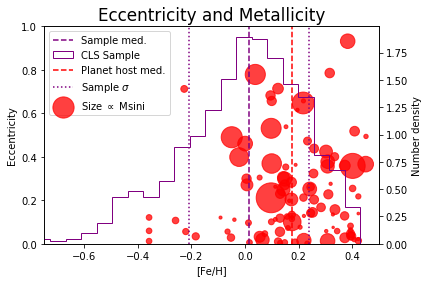

In [72]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
#plt.title('a < 5 AU, M > 0.05 MJup')
plt.title('Eccentricity and Metallicity')
#matplotlib.rcParams.update({'font.size': 14})
ln1 = ax.scatter(good_spec_filter.fe, good_spec_filter.e, s=list(50*good_spec_filter.mass), 
                alpha=0.75, c='red', label=r'Size $\propto$ Msini')

#Accurately calculate median for planet hosts, don't duplicate metallicity for each planet.
unique_fe = np.unique(good_spec_filter.fe)
median_fe = np.median(unique_fe)
mad_fe = astrostats.mad_std(unique_fe)
#matplotlib.rcParams.update({'font.size': 14})
ln2 = ax.axvline(x=median_fe, c='red', ls='--', label='Planet host med.')
#matplotlib.rcParams.update({'font.size': 14})
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Eccentricity')
ax.set_xlim([-0.75, 0.5])
ax.set_ylim([0, 1])
#matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'font.size': 10})
ax2 = ax.twinx()
ln3 = ax2.hist(fe_select, bins=40, histtype='step', color='purple', density=True, label='CLS Sample')
median_sample_fe = np.median(fe_select)
#mad_sample_fe = astrostats.median_absolute_deviation(specmatch.fe)
mad_sample_fe = astrostats.mad_std(fe_select)
ln4 = ax2.axvline(x=median_sample_fe, c='purple', ls='--', label='Sample med.')
ax.axvline(x=median_sample_fe+mad_sample_fe, c='purple', ls=':', label=r'Sample $\sigma$')
ax.axvline(x=median_sample_fe-mad_sample_fe, c='purple', ls=':')
ax2.set_ylabel('Number density')
#ax2.set_ylim([0, 1])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
matplotlib.rcParams.update({'font.size': 10})
ax2.legend(lines2 + lines, labels2 + labels, loc=2)

fig.savefig('analysis_plots/fe_eccentricity_hist.png', dpi=1000)

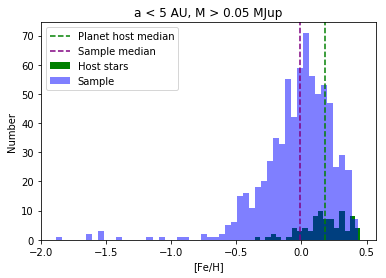

In [12]:
fig, ax = plt.subplots()
plt.title('a < 5 AU, M > 0.05 MJup')

# Accurately calculate median for planet hosts, don't duplicate metallicity for each planet.
unique_fe = np.unique(good_spec_filter.fe)
median_fe = np.median(unique_fe)
mad_fe = astrostats.mad_std(unique_fe)

ln1 = ax.hist(unique_fe, bins=20, histtype='stepfilled', color='green', 
              alpha=1, density=False, label='Host stars')
ln2 = ax.axvline(x=median_fe, c='green', ls='--', label='Planet host median')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Number')

ln3 = ax.hist(fe_select, bins=50, histtype='stepfilled', color='blue', 
               alpha=0.5, density=False, label='Sample')
median_sample_fe = np.median(specmatch.fe)
mad_sample_fe = astrostats.mad_std(specmatch.fe)
ln4 = ax.axvline(x=median_sample_fe, c='purple', ls='--', label='Sample median')

lines, labels = ax.get_legend_handles_labels()
ax.legend()

fig.savefig('planet_candidates/fe_two_hist_num.pdf')

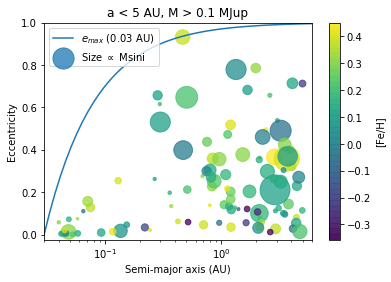

In [73]:
# Overplot peri-distance limit 0.03 AU.
axes = np.logspace(np.log10(0.03), np.log10(6))
e_max = 1 - 0.03/axes

fig, ax = plt.subplots()
plt.title('a < 5 AU, M > 0.1 MJup')
im = ax.scatter(good_spec_filter.axis, good_spec_filter.e, s=list(50*good_spec_filter.mass), 
                c=good_spec_filter.fe, alpha=0.75, label=r'Size $\propto$ Msini')
ax.plot(axes, e_max, label=r'$e_{max}$ (0.03 AU)')
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel('Eccentricity')
ax.set_xlim([0.03,6])
ax.set_ylim([-0.025,1])
ax.set_xscale('log')
ax.legend(loc=2)
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('[Fe/H]')#, rotation=270)
fig.savefig('planet_candidates/axis_eccentricity_log_lim.pdf')

## Plot eccentricity with confidence intervals.

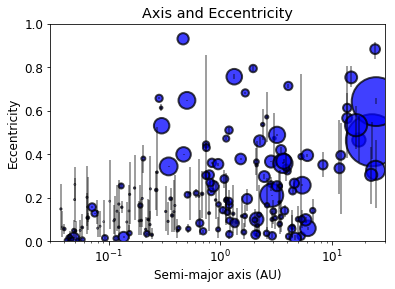

In [69]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 12})
plt.title('Axis and Eccentricity')
#plt.title('a < 5 AU, M > 0.1 MJup')
matplotlib.rcParams.update({'font.size': 12})

masses_plot = masses_planet.query('axis_plus/axis_minus < 10 and axis < 10')

'''
axerr = [masses_plot.axis_med - masses_plot.axis_minus,
         masses_plot.axis_plus - masses_plot.axis_med]
ecerr = [masses_plot.e_med - masses_plot.e_minus,
         masses_plot.e_plus - masses_plot.e_med]

ax.errorbar(masses_plot.axis, masses_plot.e_med, 
            xerr = axerr, yerr = ecerr, fmt='o',
            alpha=0.75, c='black')
            #size=list(50*masses_planet.mass), 
            #label=r'Size $\propto$ Msini')
'''
ax.scatter(masses_planet.axis_med, masses_planet.e_med, 
           s=list(30*masses_planet.mass), 
           c='blue', edgecolors='black', 
           alpha=0.75, linewidth=2,
           label=r'Size $\propto$ Msini')

# Differentiate between circular-consistent and eccentric-consistent.
ax.vlines(masses_planet.axis_med, masses_planet.e_minus,
          masses_planet.e_plus, alpha=0.5, color='black')

ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel('Eccentricity')
ax.set_xlim([0.03, 30])
ax.set_ylim([0, 1])
ax.set_xscale('log')
#ax.legend(loc=2)
fig.savefig('analysis_plots/axis_eccentricity_ci.png', dpi=1000)

## Make observational stats histograms.

In [76]:
obs_stats = pd.read_csv('legacy_tables/observation_stats.csv')
obs_stats = obs_stats.query('baseline > 2922 and Nobs > 17')
obs_stats.columns

Index(['Unnamed: 0', 'Nobs', 'Nobs_CORAVEL', 'Nobs_apf', 'Nobs_j', 'Nobs_k',
       'Nobs_lick', 'Nobs_mcdonald', 'baseline', 'baseline_CORAVEL',
       'baseline_apf', 'baseline_j', 'baseline_k', 'baseline_lick',
       'baseline_mcdonald', 'med_err_CORAVEL', 'med_err_apf', 'med_err_j',
       'med_err_k', 'med_err_lick', 'med_err_mcdonald', 'name'],
      dtype='object')

In [77]:
np.sum(obs_stats.Nobs_apf) + np.sum(obs_stats.Nobs_j) + \
    np.sum(obs_stats.Nobs_k) + np.sum(obs_stats.Nobs_lick)

59210.0

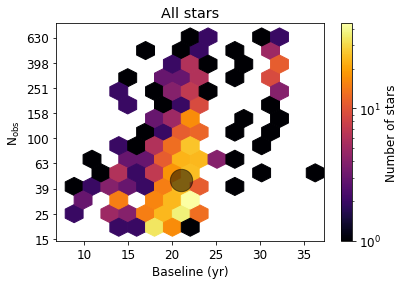

In [78]:
fig, ax = plt.subplots()

logobs   = np.log10(obs_stats.Nobs)
baseyear = obs_stats.baseline/365.25
#extent=(8.5, 35, 16, 630)
minobs  = np.amin(logobs)
maxobs  = np.amax(logobs)
minbase = np.amin(baseyear)
maxbase = np.amax(baseyear)
hard_extent = (minbase-2, maxbase+2, minobs-0.07, maxobs+0.06)

hb = ax.hexbin(baseyear, logobs, gridsize=15, bins='log', 
               extent=hard_extent, cmap='inferno', mincnt=1)

matplotlib.rcParams.update({'font.size': 12})
ax.set_title("All stars")
ax.set_xlabel('Baseline (yr)')
ax.set_ylabel(r'N$_\mathrm{obs}$')

median_base = np.median(baseyear)
median_obs  = np.log10(np.median(obs_stats.Nobs))
ax.scatter([median_base], [median_obs], color='black', 
           s=500, alpha='0.5')

# Manually set Nobs logarithmic tick marks.

def format_fn(tick_val, tick_pos):
    return str(int(10**tick_val))

#ax.locator_params(axis='y', nbins=1)
ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of stars')
fig.savefig('legacy_tables/hist_base_nobs_2D.pdf')

## Make same plot for stars with planets.

In [79]:
plnames = np.unique(masses_good.hostname)
obs_known = obs_stats.loc[obs_stats['name'].isin(plnames)]
obs_none = obs_stats.loc[~obs_stats['name'].isin(plnames)]

In [80]:
len(obs_known)

160

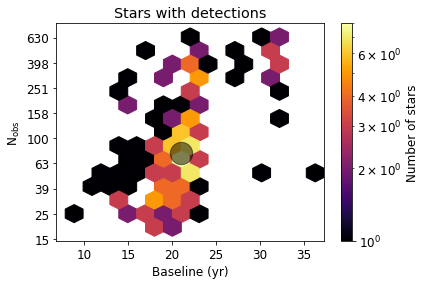

In [81]:
fig, ax = plt.subplots()
hb = ax.hexbin(obs_known.baseline/365.25, np.log10(obs_known.Nobs), 
               extent=hard_extent, gridsize=15, bins='log', 
               cmap='inferno', mincnt=1)
ax.set_title("Stars with detections")
ax.set_xlabel('Baseline (yr)')
ax.set_ylabel(r'N$_\mathrm{obs}$')

median_base = np.median(obs_known.baseline/365.25)
median_obs  = np.log10(np.median(obs_known.Nobs))
ax.scatter([median_base], [median_obs], color='black', 
           s=500, alpha='0.5')

# Manually set Nobs logarithmic tick marks.
def format_fn(tick_val, tick_pos):
    return str(int(10**tick_val))

#ax.locator_params(axis='y', nbins=1)
ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of stars')
fig.savefig('legacy_tables/hist_base_nobs_2D_planets.pdf')

In [82]:
print(np.median(obs_stats.Nobs), np.median(obs_known.Nobs), np.median(obs_none.Nobs))

47.0 76.5 40.0


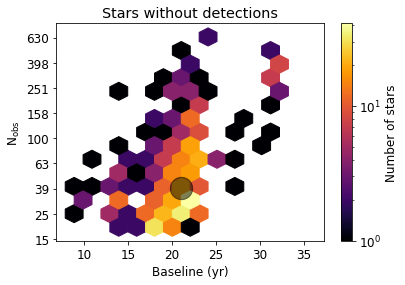

In [83]:
fig, ax = plt.subplots()
hb = ax.hexbin(obs_none.baseline/365.25, np.log10(obs_none.Nobs), 
               extent=hard_extent, gridsize=15, bins='log', 
               cmap='inferno', mincnt=1)
ax.set_title("Stars without detections")
ax.set_xlabel('Baseline (yr)')
ax.set_ylabel(r'N$_\mathrm{obs}$')
#ax.set_ylabel(r'log$_{10}$(N$_\mathrm{obs}$)')

median_base = np.median(obs_none.baseline/365.25)
median_obs  = np.log10(np.median(obs_none.Nobs))
ax.scatter([median_base], [median_obs], color='black', 
           s=500, alpha='0.5')

# Manually set Nobs logarithmic tick marks.
def format_fn(tick_val, tick_pos):
    return str(int(10**tick_val))
ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of stars')
fig.savefig('legacy_tables/hist_base_nobs_2D_none.pdf')

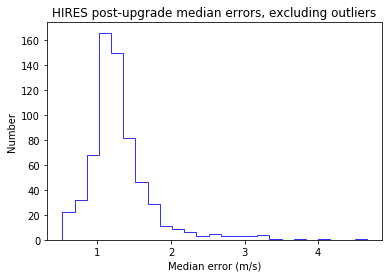

In [20]:
fig, ax = plt.subplots()
ax.hist(obs_stats.query('med_err_j < 5').med_err_j, bins=25, histtype='step', 
        color='blue', alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Median error (m/s)', ylabel='Number')
ax.set_title('HIRES post-upgrade median errors, excluding outliers')
fig.savefig('legacy_tables/hist_HIRES_post_err.pdf')

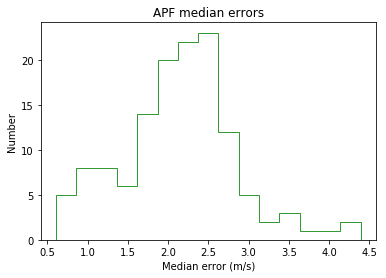

In [21]:
fig, ax = plt.subplots() #.query('med_err_j < 5')
ax.hist(obs_stats.med_err_apf, bins=15, histtype='step', color='green', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Median error (m/s)', ylabel='Number')
ax.set_title('APF median errors')
fig.savefig('legacy_tables/hist_APF_err.pdf')

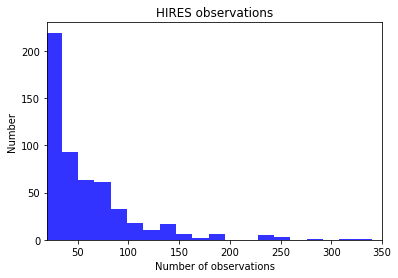

In [180]:
fig, ax = plt.subplots()
ax.hist(obs_stats.Nobs_j + obs_stats.Nobs_k, bins=20, histtype='stepfilled', color='blue', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Number of observations', ylabel='Number')
ax.set_xlim([20,350])
ax.set_title('HIRES observations')
fig.savefig('legacy_tables/hist_HIRES_nobs.pdf')

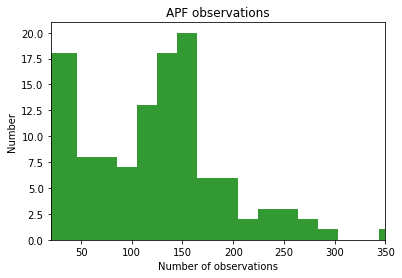

In [143]:
fig, ax = plt.subplots()
ax.hist(obs_stats.Nobs_apf, bins=20, histtype='stepfilled', color='green', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Number of observations', ylabel='Number')
ax.set_xlim([20,350])
ax.set_title('APF observations')
fig.savefig('legacy_tables/hist_APF_nobs.pdf')

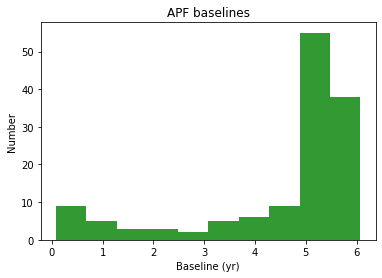

In [145]:
fig, ax = plt.subplots()
ax.hist(obs_stats.baseline_apf/365.25, bins=10, histtype='stepfilled', color='green', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Baseline (yr)', ylabel='Number')
ax.set_title('APF baselines')
fig.savefig('legacy_tables/hist_APF_base.pdf')

## Examine mass and period distributions.

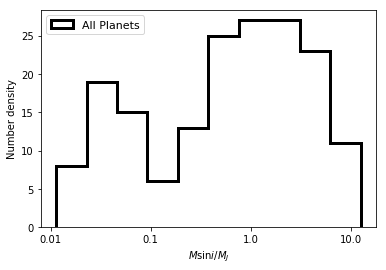

In [53]:
fig, ax = plt.subplots()
ax.hist(np.log10(masses_planet.query('mass < 15')['mass']), 
        bins=10, density=False, histtype='step',# range = (0, 1), 
        lw=3, color='black', alpha=1, label='All Planets')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i/M_J$', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 11})
#ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    #return str(int(10**tick_val))
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('planet_candidates/mass_histogram_all.png', dpi=1000)

In [88]:
masses_close = masses_planet.query('axis < 1 and mass < 15')
masses_mid   = masses_planet.query('axis > 1 and axis < 3 and mass < 15')
masses_far   = masses_planet.query('axis > 3 and mass < 15')

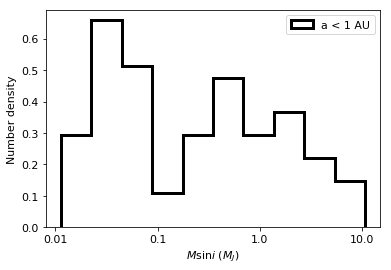

In [90]:
mclose = masses_close.mass
#thresh_close = np.log10(0.075) #50% completeness threshold

fig, ax = plt.subplots()
ax.hist(np.log10(mclose), bins=10, density=True, histtype='step',
        lw=3, color='black', alpha=1, label='a < 1 AU')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i\ (M_J)$', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 11})
#ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    #return str(int(10**tick_val))
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=1)

fig.savefig('planet_candidates/close_histogram.png', dpi=1000)

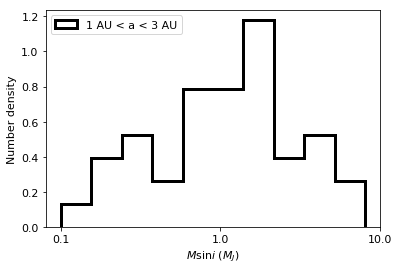

In [17]:
mmid = masses_mid.mass
thresh_mid = np.log10(0.15) #50% completeness threshold

fig, ax = plt.subplots()
ax.hist(np.log10(mmid), bins=10, density=True, histtype='step',
        lw=3, color='black', alpha=1, label='1 AU < a < 3 AU')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i\ (M_J)$', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 11})
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    #return str(int(10**tick_val))
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('planet_candidates/mid_histogram.png', dpi=1000)

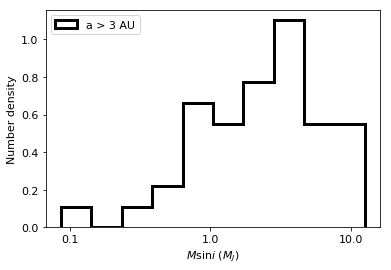

In [18]:
mfar = masses_far.mass
thresh_far = np.log10(1.2) #50% completeness threshold

fig, ax = plt.subplots()
ax.hist(np.log10(mfar), bins=10, density=True, histtype='step',
        lw=3, color='black', alpha=1, label='a > 3 AU')

matplotlib.rcParams.update({'font.size': 11})
ax.set(xlabel=r'$M\mathrm{sin}i\ (M_J)$', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 11})
        
def format_fn(tick_val, tick_pos):
    return str(10**tick_val)
    #return str(int(10**tick_val))
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 11})
ax.legend(loc=2)

fig.savefig('planet_candidates/far_histogram.png', dpi=1000)

## Make distributions of periods and period ratios.

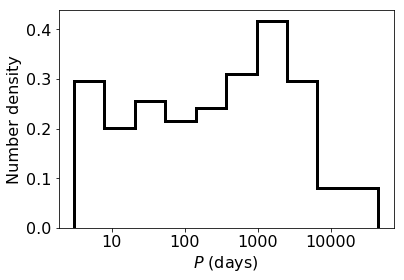

In [48]:
fig, ax = plt.subplots()
ax.hist(np.log10(masses_planet.per), bins=10, density=True, histtype='step',
        lw=3, color='black', alpha=1)#, label='1 AU < a < 3 AU')

matplotlib.rcParams.update({'font.size': 18})
ax.set(xlabel=r'$P$ (days)', 
          ylabel='Number density')
matplotlib.rcParams.update({'font.size': 18})
        
def format_fn(tick_val, tick_pos):
    #return str(10**tick_val)
    return str(int(10**tick_val))
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))   
matplotlib.rcParams.update({'font.size': 16})
#ax.legend(loc=2)

fig.savefig('planet_candidates/per_histogram.png', dpi=1000)

In [133]:
def period_ratios(pers):
    ratios = []
    nplanets = len(pers)
    sorted = np.sort(pers)
    for i in np.arange(nplanets):
        for j in np.arange(i):
            ratios.append(sorted[i]/sorted[j])
    return ratios

In [134]:
systems = masses_planet.hostname.unique()

In [135]:
all_ratios = []
for system in systems:
    sys_db = masses_planet.query('hostname == "{}"'.format(system))#    .loc[masses_planet.hostname == system]
    if len(sys_db) > 1:
        sys_ratios = period_ratios(sys_db.per)
        all_ratios.append(sys_ratios)
all_ratios = np.concatenate(all_ratios)

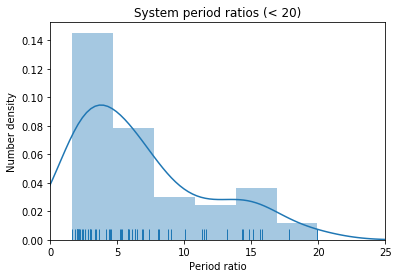

In [136]:
# Only use ratios below 20.
filtered_ratios = np.extract(all_ratios < 20, all_ratios)
axper = sns.distplot(filtered_ratios, rug=True)
axper.set_xlim([0,25])
axper.set(xlabel='Period ratio', ylabel='Number density')
axper.set_title('System period ratios (< 20)')

figper = axper.get_figure()
figper.savefig('planet_candidates/period_ratio_histogram.pdf')

## Do some preliminary work on giant multis.

In [31]:
planets_big_all   = masses_planet.query('mass > 0.1')
planets_small_all = masses_planet.query('mass <= 0.1')

names_big_all = np.unique(planets_big_all.hostname)
nplanets_big_all = np.array(planets_big_all.groupby('hostname').count()['status'])
db_nplanets_big_all = pd.DataFrame({'hostname':names_big_all, 'nplanets':nplanets_big_all})

names_small_all = np.unique(planets_small_all.hostname)
nplanets_small_all = np.array(planets_small_all.groupby('hostname').count()['status'])
db_nplanets_small_all = pd.DataFrame({'hostname':names_small_all, 'nplanets':nplanets_small_all})

# Do same nplanets thingy for all planets, no mass cuts.
names_all = np.unique(masses_planet.hostname)
nplanets_all = np.array(masses_planet.groupby('hostname').count()['status'])
db_nplanets_all = pd.DataFrame({'hostname':names_all, 'nplanets':nplanets_all})

planets_all       = pd.merge(masses_planet, db_nplanets_all, on='hostname').reset_index()
planets_big_all   = pd.merge(planets_big_all, db_nplanets_big_all, on='hostname').reset_index()
planets_small_all = pd.merge(planets_small_all, db_nplanets_small_all, on='hostname').reset_index()

db_nplanets_all       = None
db_nplanets_big_all   = None
db_nplanets_small_all = None

In [32]:
planets_big_multi_all = planets_big_all.query('nplanets > 1')
planets_multi_all     = planets_all.query('nplanets > 1')

In [33]:
planets_big_multi_all.query('axis < 0.1')

,index,Unnamed: 0,hostname,status,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,per_plus,k,k_med,k_minus,k_plus,e,e_med,e_minus,e_plus,nplanets
53,53,105,187123,K,0.506373,0.506559,0.486685,0.526043,0.042075,0.042076,...,3.096599,68.949742,68.975676,68.706070,69.243043,0.004495,0.003601,0.001081,0.007340,2
65,65,140,217107,K,1.431095,1.431618,1.364445,1.496929,0.075125,0.075134,...,7.126882,141.846736,141.870364,141.604159,142.138018,0.128338,0.128082,0.126377,0.129803,2
113,113,249,9826,K,0.661731,0.661570,0.626295,0.696077,0.058421,0.058415,...,4.617128,69.685089,69.687528,68.988786,70.382609,0.006143,0.007490,0.002219,0.015544,3
131,131,300,68988,K,1.969198,1.970428,1.885562,2.053510,0.071213,0.071212,...,6.276428,192.104859,192.214938,191.571474,192.855609,0.157166,0.156755,0.153332,0.160005,2


In [34]:
planets_big_multi_all.query('hostname in ["187123", "217107", "9826", "68988"] and axis > 10')

,index,Unnamed: 0,hostname,status,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,per_plus,k,k_med,k_minus,k_plus,e,e_med,e_minus,e_plus,nplanets
132,132,301,68988,K,16.389258,17.617583,15.124601,19.992019,14.353306,16.508762,...,32532.222445,126.453866,132.159067,120.845171,141.813569,0.475855,0.533665,0.424231,0.623832,2


## P(HJ | Outer > 10 AU)

In [35]:
planets_outer = planets_big_multi_all.query('axis > 10')
planets_outer.hostname

1      145675
89      50499
94      66428
132     68988
Name: hostname, dtype: object

In [42]:
prob_outer = len(planets_big_multi_all.query('hostname in @planets_outer.hostname \
                 and axis < 0.1'))/float(len(planets_outer))
sig_outer = np.sqrt(float(len(planets_big_multi_all.query('hostname in @planets_outer.hostname \
                    and axis < 0.1')))) / len(planets_outer)
print(prob_outer, '+\-', sig_outer)

0.25 +\- 0.25


## P(HJ | 10 AU > Outer > 4.64 AU)

In [44]:
planets_med = planets_big_multi_all.query('axis < 10 and axis > 4.64')
planets_med.hostname

15        114783
26        134987
37        156279
51        183263
66        217107
71         24040
83          4203
99         75732
107        92788
121        gl317
123    hip109388
Name: hostname, dtype: object

In [46]:
prob_med = len(planets_big_multi_all.query('hostname in @planets_med.hostname \
               and axis < 0.1'))/float(len(planets_med))
sig_med = np.sqrt(len(planets_big_multi_all.query('hostname in @planets_med.hostname \
                  and axis < 0.1')))/float(len(planets_med))
print(prob_med, '+\-', sig_med)

0.09090909090909091 +\- 0.09090909090909091


## P(HJ | 4.64 AU > Outer > 2.15 AU)

In [47]:
planets_inner = planets_big_multi_all.query('axis < 4.64 and axis > 2.15')
planets_inner.hostname

0         145675
10        108874
20         12661
32        141399
43        168443
46        169830
54        187123
79         38529
88         50499
92         52265
93         66428
96         74156
111        95128
115         9826
122    hip109388
130        37124
Name: hostname, dtype: object

In [48]:
prob_inner = len(planets_big_multi_all.query('hostname in @planets_inner.hostname \
                 and axis < 0.1'))/float(len(planets_med))
sig_inner = np.sqrt(len(planets_big_multi_all.query('hostname in @planets_inner.hostname \
                 and axis < 0.1')))/float(len(planets_med))
print(prob_inner, '+\-', sig_inner)

0.18181818181818182 +\- 0.128564869306645


## Hot Jupiter Occurrence.

In [86]:
hot_jupiters = masses_planet.query('axis < 0.1 and mass > 0.1 and hostname != "102195"')
#hot_jupiters = masses_planet.query('per < 10 and mass > 0.1')
nhot = len(hot_jupiters)
nstars = len(specmatch)
print(nhot/(nstars-1), '+/-', np.sqrt(nhot)/nstars)

0.018055555555555554 +/- 0.0050007645984243955


In [85]:
nhot

13

### Wright et al. finds 0.0120 +/- 0.0038. We find more Hot Jupiters, but our results are statistically consistent within ~1.5 sigma.

### Plot completeness contours.

In [23]:
cumming_20 = pd.read_csv('completeness_contours/cumming_20.csv', names=['logP', 'logM'])
cumming_80 = pd.read_csv('completeness_contours/cumming_80.csv', names=['logP', 'logM'])
mayor_20   = pd.read_csv('completeness_contours/mayor_20.csv', names=['logP', 'logM'])
mayor_80   = pd.read_csv('completeness_contours/mayor_80.csv', names=['logP', 'logM'])

In [24]:
cumming_20

,logP,logM
0,0.068881,-1.452504
1,0.142681,-1.435233
2,0.211562,-1.400691
3,0.275523,-1.369603
4,0.344403,-1.359240
...,...,...
69,3.842558,0.257340
70,3.891759,0.326425
71,3.916359,0.392055
72,3.950800,0.454231


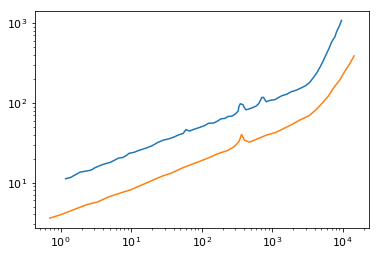

In [27]:
fig, ax = plt.subplots()
ax.plot(10**cumming_20.logP, 10**cumming_20.logM*317.8)
ax.plot(10**mayor_20.logP, 10**mayor_20.logM)
ax.set_xscale('log')
ax.set_yscale('log')